In [1]:
import os
import time

import geoutils as gu
import numpy as np
import pyperclip as pc

from itertools import product
from dataclasses import dataclass
from matplotlib import pyplot as plt
from IPython.display import clear_output
from scipy.ndimage import convolve
from scipy.ndimage.measurements import label
from PIL import Image

np.set_printoptions(linewidth=200)

In [10]:
fns = [fn for fn in os.listdir("data") if fn.endswith(".tif")]
rasters = sorted([gu.Raster(os.path.join("data", fn)) for fn in fns], key=lambda r: r.bounds[:2])

raster = rasters[0]
print(raster)

Driver:               GTiff 
Opened from file:     E:\Projects\polycraft\heightmap\data\swissalti3d_2021_2532-1151_0.5_2056_5728.tif 
Filename:             data\swissalti3d_2021_2532-1151_0.5_2056_5728.tif 
Raster modified since disk load?  False 
Size:                 2000, 2000
Number of bands:      1
Data types:           ('float32',)
Coordinate System:    EPSG:2056
NoData Value:         -9999.0
Pixel Size:           0.5, 0.5
Upper Left Corner:    2532000.0, 1151000.0
Lower Right Corner:   2533000.0, 1152000.0



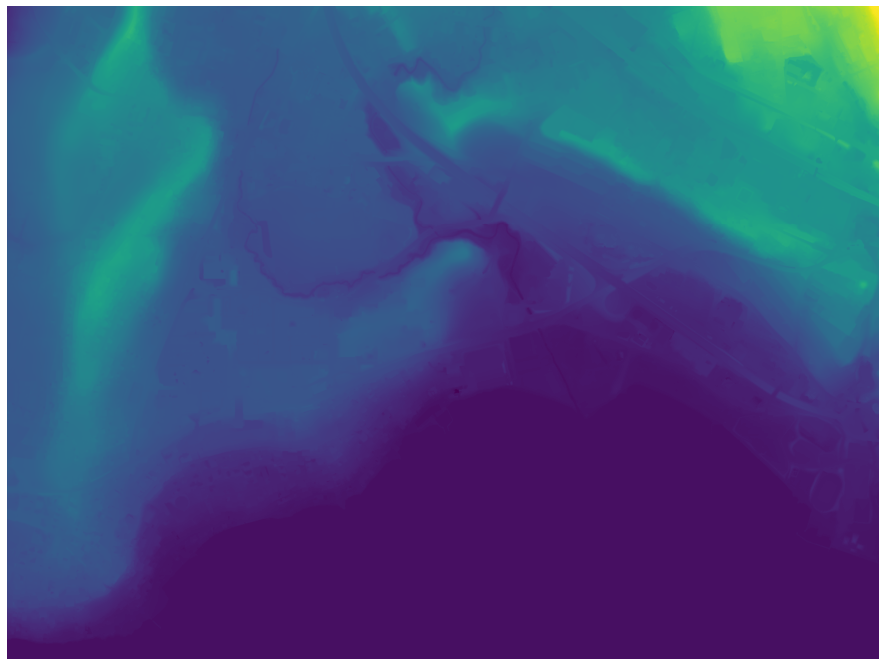

In [11]:
h, w = (3, 4)
factor = 4
figsize = (factor * w, factor * h)
fig, ax = plt.subplots(h, w, figsize=figsize)

vMin, vMax = None, None

for r in rasters:
    tMin = r.data.min()
    tMax = r.data.max()
    
    if vMin is None:
        vMin = tMin
        vMax = tMax
    else:
        vMin = min(vMin, tMin)
        vMax = max(vMax, tMax)

for i, j in product(range(h), range(w)):
    rasters[h * j + i].show(ax=ax[h - i - 1, j], vmin=vMin, vmax=vMax, add_cb=False)
    ax[h - i - 1, j].axis('off')
    
plt.subplots_adjust(wspace=-0.09, hspace=0)

plt.show()

In [12]:
def make_affine(x0_old, x0_new, x1_old, x1_new):
    m = (x0_new - x1_new) / (x0_old - x1_old)
    h = (x1_new * x0_old - x0_new * x1_old) / (x0_old - x1_old)
    
    return m, h

def make_affine_matrix_1d(m, h):
    return np.array([
        [m, h],
        [0, 1]
    ])

def make_affine_matrix_2d(mX, mZ, hX, hZ):
    return np.array([
        [mX, 0, hX],
        [0, mZ, hZ],
        [0,  0,  1]
    ])

def convert_points(points, mat):
    points = np.c_[ points, points.shape[0]]
    return np.matmul(mat, points)

def getV(rasters, lon, lat):
    r = find_raster(rasters, lon, lat)
    
    if r is None:
        return None
    
    return r.value_at_coords(lon, lat)

In [13]:
def mapTopLeft(mX, mZ):
    return mX * 128 - 64, mZ * 128 - 64

def fits_bb(raster, lon, lat):
    bb = raster.bounds
    lonFit = bb.left <= lon <= bb.right
    latFit = bb.bottom <= lat <= bb.top
    return lonFit, latFit

def find_raster(rasters, lon, lat):
    for r in rasters:
        if sum(fits_bb(r, lon, lat)) == 2:
            return r
        
    return None

def xzTrans(m2c, x, z):
    trans = np.matmul(m2c, [x, z, 1])
    return tuple(trans[:2])
    
def raster_ranges(rasters, m2c, c2m, xS, zS, xE, zE):
    points = [(xS, zS)]
    ranges = []
    lonEnd, latEnd = xzTrans(m2c, xE, zE)
    
    while points:
        x0, z0 = points.pop()
        lon0, lat0 = xzTrans(m2c, x0, z0)
        
        raster = find_raster(rasters, lon0, lat0)
        
        if raster is None:
            raise ValueError("A raster is missing for longitude", lon, "and latitude", lat)
            
        lonFit, latFit = fits_bb(raster, lonEnd, latEnd)
        xB, zB = xzTrans(c2m, raster.bounds.right, raster.bounds.bottom)
        xB, zB = int(xB // 1), int(zB // 1)
        x1 = xE if lonFit else xB
        z1 = zE if latFit else zB
        
        ranges.append((raster, x0, z0, x1, z1))
        
        if not lonFit:
            points.append((xB + 1, z0))
            
        if not latFit and x0 == xS:
            points.append((x0, zB + 1))
            
    return ranges
            
def gen_heightmap(rasters, m2c, c2m, v2y, xMap, zMap):
    xS, zS = mapTopLeft(xMap, zMap)
    xE, zE = xS + 127, zS + 127
    ranges = raster_ranges(rasters, m2c, c2m, xS, zS, xE, zE)
    ret = np.zeros((128, 128))
    
    xFixes, zFixes = [], []
    
    for raster, x0, z0, x1, z1 in ranges:
        w = x1 - x0 + 1
        h = z1 - z0 + 1
        coords = np.array(list(product(range(w), range(h)))).T
        ones = np.ones((1, coords.shape[1]))
        matrix = np.r_[coords, ones]
        matrix[0] = matrix[0] + x0
        matrix[1] = matrix[1] + z0
        real_coords = np.matmul(m2c, matrix)[:2].T
        heights = raster.interp_points(pts=real_coords)
        
        sub_ret = np.zeros((w, h))
        sub_ret[tuple(coords)] = heights
        xShift, zShift = x0 - xS, z0 - zS
        ret[xShift:xShift + w, zShift:zShift + h] = sub_ret
        
        if x0 != xS:
            xFixes.append(x0)
            
        if z0 != zS:
            zFixes.append(z0)
            
    for fix in xFixes:
        x = fix - xS - 1
        ret[x, :] = (ret[x + 1, :] + ret[x - 1, :]) / 2
        
    for fix in zFixes:
        z = fix - zS - 1
        ret[:, z] = (ret[:, z + 1] + ret[:, z - 1]) / 2
        
    coords = np.array(list(product(range(128), range(128)))).T
    retF = np.array(ret.flatten())
    matrix = np.c_[retF.T, np.ones((retF.shape[0]))].T
    matrix = np.matmul(v2y, matrix)
    ret[tuple(coords)] = matrix[0]
    
    return np.around(ret).T.astype(int)

In [14]:
x0, z0 =  -170, -196
x1, z1 = -1144,  284

w0, h0 = 2533405,   1152605.5
w1, h1 = 2532702.5, 1152259.5

lonField, latField = 2534190, 1152375
lonEspla, latEspla = 2533030, 1152475

v0 = getV(rasters, lonField, latField)
v1 = getV(rasters, lonEspla, latEspla)

y0, y1 = 35, 67

In [15]:
mX, hX = make_affine(x0, w0, x1, w1)
mZ, hZ = make_affine(z0, h0, z1, h1)

m2c = make_affine_matrix_2d(mX, mZ, hX, hZ)

mX, hX = make_affine(w0, x0, w1, x1)
mZ, hZ = make_affine(h0, z0, h1, z1)

c2m = make_affine_matrix_2d(mX, mZ, hX, hZ)

mY, hY = make_affine(v0, y0, v1, y1)

v2y = make_affine_matrix_1d(mY, hY)

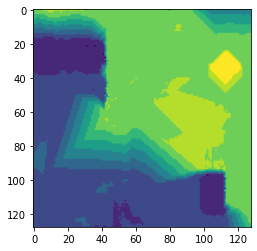

In [16]:
arr = gen_heightmap(rasters, m2c, c2m, v2y, -6, 0)
plt.imshow(arr)
plt.show()

# JUNKYARD

In [ ]:
base = np.ones(tsrct.shape)
trans = np.transpose(base, axes=[0, 2, 1, 3])
cut = np.tril(trans[::, ::-1, ::, ::])[::, ::, ::-1, ::]
detrans = np.transpose(cut, axes=[3, 1, 2, 0])
show_tsrct(detrans)

In [231]:
base = np.ones(tsrct.shape)
trans = np.transpose(base, axes=[2, 0, 3, 1])
cut = np.triu(trans[::-1, ::, ::, ::])[::, ::, ::, ::-1]
detrans = np.transpose(cut, axes=[1, 3, 0, 2])
#show_tsrct(detrans)

In [2]:
simple_str = "010110111"
simple_2_str = "001110111"
stairs_str = "1111111011101000"
star_str = "0010001110111110111000100"
hat_str = "0010001110111110001000000"
fish_str = "0000110000000110000100111100110111111010110111111001111110100011110011000110000100001100000000011000"
boat_str = "0000010000001111111000011111000001111100000111110000111111100000010000111111111101111111110011111110"
africa_str = """000011000000000001111110000000011111111110000011111111111000111111111111100111111111111110111111111111100011100111111100000000111111100000001111111000000001111110010000001111110010000000111110010000000111100000000000011000000"""
dk_str = """0000011111000000000000011111111000000000000101000110000000000011000001111100000000101010001111100000011010100011111100001100000001111111000010101000011111111000100000011011111110001111111100111111110011000000011111111110011111111101111111100001100000011111111000011111110111101110000111100111111111000001111000011111110000011110011111111100000101010101001111100001000101000010001000011111011111111110"""
coq_str = """0000011011000000000000001111100000000000000011111100000111000001100110000111111001110100100011111111001100001001111111110001000011011111100100010000011111111100000100001111111111100001001111111111111100011100011111111111000010000111111111010000110000111111110000000100000011111000000001100001110000000000001100111100000000001111111110000000000010000001000000000000000000010000000000000000011100000000"""
america_str = """0000110000000000000000011110001101011000000111111100000110000000011111101100100000000111100010000000000011111101000000000000111111110000000000000111111000000000000001110100000000000000011000010000000000000011110000000000000000001110000000000000000011111000000000000000111111000000000000000111110000000000000001111000000000000000011100000000000000000110000000000000000001000000000000000000001000000000"""
square_str = ("0" * 40) + (("0" + ("1" * 38) + "0") * 38) + ("0" * 40)

def arr_from_str(string, h, w):
    ret = np.zeros((h, w), dtype=bool)
    k = 0

    for i in range(h):
        for j in range(w):
            while string[k] == "\n":
                k += 1
                
            ret[i, j] = string[k] == "1"
            k += 1
            
    return ret

def tile(arr, times):
    sub = np.concatenate([arr] * times)
    return np.concatenate([sub] * times, axis=1)

coq_arr =      arr_from_str(coq_str,     20, 20)
dk_arr =       arr_from_str(dk_str,      20, 20)
america_arr =  arr_from_str(america_str, 20, 20)
africa_arr =   arr_from_str(africa_str,  15, 15)
square_arr =   arr_from_str(square_str,  40, 40)
star_arr =     arr_from_str(star_str,     5,  5)
hat_arr =      arr_from_str(hat_str,      5,  5)
simple_arr =   arr_from_str(simple_str,   3,  3)
simple_2_arr = arr_from_str(simple_2_str, 3,  3)
fish_arr =     arr_from_str(fish_str,    10, 10)
super_dk_arr = tile(dk_arr, 6)
im = Image.open("worldmap.bmp")
p = np.array(im)

arr = p

big_world_arr = np.tile(p,        reps=(2, 2))[:128, :128]
big_dk_arr =    np.tile(dk_arr,   reps=(7, 7))[:128, :128]
big_fish_arr =  np.tile(fish_arr, reps=(13, 13))[:128, :128]

## Running Space

In [3]:
def show_tsrct(tsrct, factor=1):
    h, w = tsrct.shape[:2]
    figsize = (factor * h, factor * w)
    fig, ax = plt.subplots(h, w, figsize=figsize)

    for i, j in product(range(h), range(w)):
        ax[i, j].imshow(tsrct[i, j], vmin=0, vmax=1)

In [6]:
start = time.time()

times = [start]

# Generate tesseract, scores, and fills arrays
tsrct = gen_tesseract_opt(arr)
times.append(time.time())
mask = gen_tesseract_opt(np.ones(arr.shape), carve=False)

times.append(time.time())
scores = gen_block_scores_opt(tsrct)
times.append(time.time())
fills = gen_redundant_fills_opt(tsrct, arr)
times.append(time.time())
coords_gen = gen_coords_generator(tsrct)
times.append(time.time())
# Iteratively select the best fills
while select_next_fill_opt(tsrct, scores, fills, coords_gen, mask, arr):
    pass
times.append(time.time())
# Remove redundant fills
sanitize(tsrct, scores)
times.append(time.time())
# Shrink fills to their minimum useful size
shrink(tsrct, scores)
times.append(time.time())

    
print([b-a for a, b in zip(times[:-1], times[1:])])

end = time.time()
print(end - start)
print(scores)

[0.1069633960723877, 0.03499102592468262, 1.8704004287719727, 0.015007734298706055, 0.0, 0.8277220726013184, 0.17295598983764648, 0.16994619369506836]
3.1989963054656982
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Display

254 commands


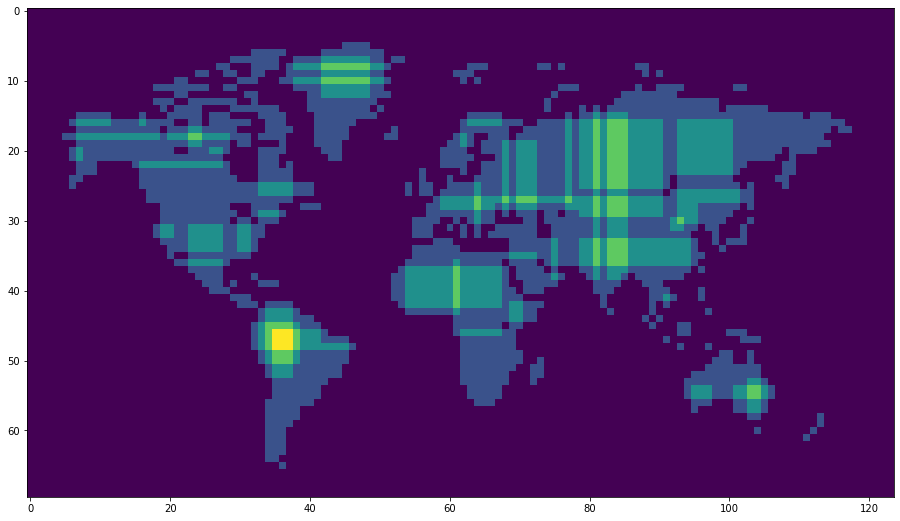

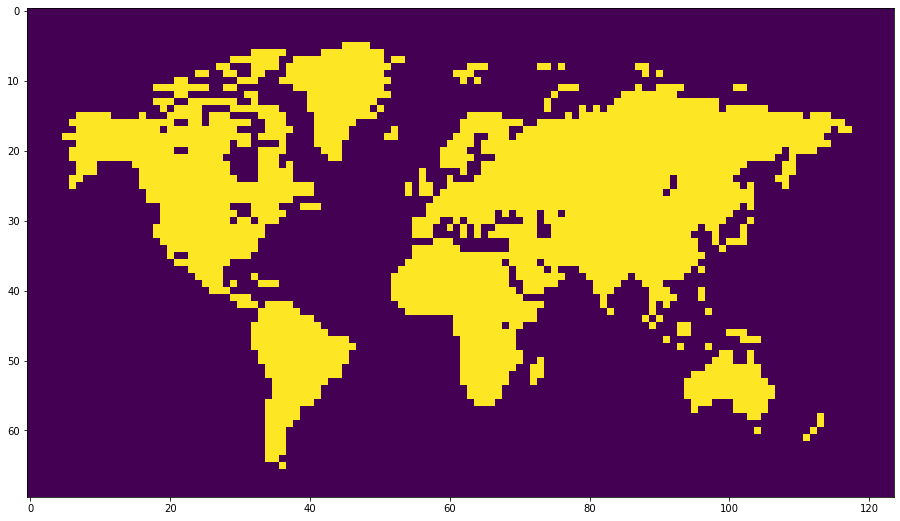

In [9]:
by_step = False
x = 0
canvas = np.zeros(tsrct.shape[:2])

for h, w, i, j in sorted(np.column_stack(tsrct.nonzero()), key=lambda t: (-t[0], -t[1])):
    mem = np.zeros(tsrct.shape[:2])
    mem[i:i + h + 1, j:j + w + 1] += 1

    if by_step:
        plt.figure(figsize = (16, 9))
        plt.imshow(2 * (mem - canvas).clip(min=0) + mem)
        plt.show()

    canvas += mem

    if by_step:
        plt.imshow(canvas)
        plt.show()
        input("Press Enter")
        clear_output()

    x += 1
    
print(x, "commands")
plt.figure(figsize = (16, 9))
plt.imshow(canvas)
plt.show()
plt.figure(figsize = (16, 9))
plt.imshow(canvas > 0)
plt.show()

# Layering Functions

In [52]:
prefix = "summon falling_block ~ ~1 ~ {Time:1,BlockState:{Name:redstone_block},Passengers:[\
{id:armor_stand,Health:0,Passengers:[\
{id:falling_block,Time:1,BlockState:{Name:activator_rail},Passengers:[\
{id:command_block_minecart,Command:'gamerule commandBlockOutput false'},\
{id:command_block_minecart,Command:'data merge block ~ ~-2 ~ {auto:0}'},"

template = "{{id:command_block_minecart,Command:'{0}'}}"

fill_command = "fill {0} {1} {2} {3} {4} {5} {6} {7} {8}"

clone_command = "clone {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10}"

suffix = ",{id:command_block_minecart,Command:'setblock ~ ~1 ~ command_block{auto:1,Command:\"fill ~ ~ ~ ~ ~-2 ~ air\"}'},\
{id:command_block_minecart,Command:'kill @e[type=command_block_minecart,distance=..1]'}]}]}]}"

strings = {
    "prefix": prefix,
    "template": template,
    "fill_command": fill_command,
    "clone_command": clone_command,
    "suffix": suffix
}

In [91]:
def gen_fill(strings, edges, Y, block0, mode=None, block1=None):
    h, w, X0, Z0 = edges
    X1 = X0 + h
    Z1 = Z0 + w
    
    if mode == "keep":
        pass
    elif mode == "replace":
        if block1 is None:
            raise ValueError
    elif mode is None:    
        mode = ""
    else:
        raise ValueError
        
    if block1 is None:
        block1 = ""
    else:
        if mode != "replace":
            raise ValueError
        
    cmd = strings["fill_command"].format(X0, Y, Z0, X1, Y, Z1, block0, mode, block1).strip()
    return strings["template"].format(cmd)
            
def gen_clone(strings, edges, Y0, yShift, mode, block=None):
    h, w, X0, Z0 = edges
    X1 = X0 + h
    Z1 = Z0 + w
    Y1 = Y0 + yShift
    
    if mode == "replace" or mode == "masked":
        pass
    elif mode == "filtered":
        if block is None:
            raise ValueError
    else:
        raise ValueError
        
    if block is None:
        block = ""
    else:
        if mode != "filtered":
            raise ValueError
        
    cmd = strings["clone_command"].format(X0, Y0, Z0, X1, Y0, Z1, X0, Y1, Z0, mode, block).strip()
    return strings["template"].format(cmd)

def package_commands(cmds, strings):
    max_chars = 32500
    prefix = strings["prefix"]
    suffix = strings["suffix"]
    
    def_len = len(prefix) + len(suffix)
    avail_space = max_chars - def_len
    lens = [len(cmd) + 1 for cmd in cmds]
    
    idx = 0
    batches = []
    
    while lens:
        idx = (np.cumsum(lens) <= avail_space).argmin(0)
        
        if idx == 0:
            idx = len(cmds)
            
        string = prefix + ",".join(cmds[:idx]) + suffix
        batches.append(string)
        lens = lens[idx:]
        cmds = cmds[idx:]
        
    for i, b in enumerate(batches):
        input("Press Enter to store the next command in your clipboard...")
        pc.copy(b)
        print(f"Batch {i + 1} of {len(batches)}")
        
def thicken_old(multilayer):
    ret = np.zeros(multilayer.shape, dtype=bool)
    mem = np.zeros(multilayer.shape[:2], dtype=bool)
    
    for z in range(multilayer.shape[2]):
        ret[..., z] = (multilayer[..., z] > 0) | mem
        mem = ret[..., z]
        
    return ret[..., ::-1]

def thicken(arr):
    bottom = np.min(arr)
    top = np.max(arr)
    depth = top - bottom + 1
    ret = np.zeros(arr.shape + (depth,), dtype=bool)

    for d in range(depth):
        ret[..., d] = (arr == bottom + d)

    return ret, bottom, depth
        
def split_layer(layer):
    structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
    labeled, N = label(layer, structure)
    background_label = None if N == 1 else labeled[tuple(np.column_stack(np.where(layer == 0))[0])]
    ret = []
    
    for idx in range(1, N + 1):
        if background_label is None:
            idx = layer[0, 0]
        elif background_label == idx:
            continue
            
        component = (labeled == idx)
        j0, j1 = tuple(np.argwhere(np.any(component, axis=0))[[0, -1]].flatten().tolist())
        i0, i1 = tuple(np.argwhere(np.any(component, axis=1))[[0, -1]].flatten().tolist())
        
        ret.append((i1 - i0, j1 - j0, i0, j0))
        
    return ret

def tesselate_layer(layer, h0, w0, i0, j0):
    #Trivial case
    if len(np.unique(layer)) == 1:
        return [(h0, w0, i0, j0)]
    
    # Slice out the wanted part
    sub_layer = layer[i0:i0 + h0 + 1, j0:j0 + w0 + 1]
    
    # Initialize working arrays
    possible =   gen_tesseract_opt(sub_layer)
    selected =   np.zeros(possible.shape)
    mask =       gen_mask(possible)
    coords_gen = gen_coords_generator(possible)

    # Iteratively select the best fills
    while select_next_fill(selected, possible, coords_gen, mask, sub_layer):
        pass

    # Generate scores
    scores = gen_scores_post(selected)

    # Remove redundant fills
    sanitize(selected, scores)

    # Shrink fills to their minimum useful size
    shrink(selected, scores)
    
    return [(h, w, i + i0, j + j0) for h, w, i, j in np.column_stack(selected.nonzero()).tolist()]

def cubify(arr, strings, shift=(0, 0)):
    multilayer, Y0, depth = thicken(arr.T)
    border = arr.shape + shift
    cmds = []
    
    for y in range(depth):
        layer = multilayer[..., y]
        sublayers = split_layer(layer)
        edges = []
        
        for (h, w, i, j) in sublayers:
            edges += tesselate_layer(layer, h, w, i, j)
            
        cmds += [gen_fill(strings, elem, Y0 + y, "diamond_block", mode="replace", block1="air") for elem in edges]
    
    package_commands(cmds, strings)

In [89]:
heightmap = np.dstack([big_fish_arr & big_dk_arr & big_world_arr, (1 - big_fish_arr) & big_dk_arr & big_world_arr, (1 - big_dk_arr) & big_world_arr, (1 - big_world_arr)])[:, ::-1, :]
#heightmap = np.dstack([big_world_arr, (1 - big_world_arr) & np.ones(big_world_arr.shape, dtype=bool)])[:, ::-1]
cubify(arr, strings)

Press Enter to store the next command in your clipboard... 


Batch 1 of 3


Press Enter to store the next command in your clipboard... 


Batch 2 of 3


Press Enter to store the next command in your clipboard... 


Batch 3 of 3


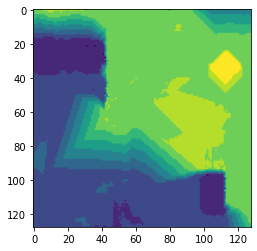

In [55]:
plt.imshow(arr)

In [4]:
def gen_border(arr):
    h, w = arr.shape
    edge = np.ones((h, w), dtype=bool)
    edge[1:h-1,1:w-1] = 0
    
    dirs = [round(np.sin(i * np.pi / 2)) for i in range(4)]
    empties = arr == 0
    mem = empties.copy()
    
    for roll in zip(dirs, np.roll(dirs, -1)):
        mem += np.roll(empties, roll, axis=(0, 1))
        
    return (mem + edge) * (arr > 0)

def gen_bound_mask(arr):
    h, w = arr.shape
    ret = np.zeros((h, w, h, w), dtype=bool)
    
    for i, j in np.column_stack((1 - arr).nonzero()):
        set_block_at(ret, i, j, True)
        
    return ret

# More performant than gen_tesseract(np.ones(tsrct.shape[:2]))
def gen_mask(tsrct):
    h, w = tsrct.shape[:2]
    mask = np.ones(tsrct.shape, dtype=bool)

    for i in range(h):
        mask[i, :, h - i:h, :] = 0

    for j in range(w):
        mask[:, j, :, w - j:w] = 0

    return mask

def gen_tesseract_opt_sub(arr, true_if_and):
    h, w = arr.shape
    ret = np.zeros((h, w, h, w), dtype=bool)
    ret[0, 0] = arr > 0

    for i in range(1, h):
        curr = ret[i - 1, 0]
        roll = np.roll(curr, -1, axis=0)
        roll[-1] = False
        ret[i, 0] = curr & roll if true_if_and else curr | roll

    for j in range(1, w):
        curr = ret[:, j - 1]
        roll = np.roll(curr, -1, axis=2)
        roll[:, :, -1] = False
        ret[:, j] = curr & roll if true_if_and else curr | roll
        
    return ret

def gen_tesseract_opt(arr, carve=True):
    border = gen_border(arr)
    ret = gen_tesseract_opt_sub(arr, True)
    
    if carve:
        no_fillers = gen_tesseract_opt_sub(border, False)
        ret = ret & no_fillers
        
    return ret

In [30]:
def modify_fill_at(tsrct, scores, h, w, i, j, true_if_add):
    tsrct[h, w, i, j] = true_if_add
    scores[i:i + h + 1, j:j + w + 1] -= -1 if true_if_add else 1

def remove_fill_at(tsrct, scores, h, w, i, j):
    modify_fill_at(tsrct, scores, h, w, i, j, False)
    
def add_fill_at(tsrct, scores, h, w, i, j):
    modify_fill_at(tsrct, scores, h, w, i, j, True)
    
def yield_coords(possible, gen):
    try:
        while True:
            h, w, i, j = next(gen)
            
            if possible[h, w, i, j]:
                return h, w, i, j
    except StopIteration:
        return None

def gen_coords_generator(possible):
    h, w = possible.shape[:2]
    order = sorted(np.column_stack(possible.nonzero()), key=lambda elem: (-max(elem[:2]), -elem[0], -elem[1]))
    
    for h0, w0, i0, j0 in order:
        yield h0, w0, i0, j0
    
def select_next_fill(selected, possible, gen, mask, arr):
    H, W = arr.shape
    coords = yield_coords(possible, gen)
    
    if coords is None:
        return False
    
    h, w, i, j = coords
    selected[h, w, i, j] = True
    
    slc = np.index_exp[:h + 1, :w + 1, i:i + h + 1, j:j + w + 1:]
    sub_possible = possible[slc]
    sub_mask = mask[H - h - 1:, W - w - 1:, :h + 1, :w + 1]
    possible[slc] = sub_possible & (1 - (sub_mask & sub_possible))
    
    return True
    
def gen_scores_post(selected):
    ret = np.zeros(selected.shape[:2], dtype=np.int16)
    
    for h, w, i, j in np.column_stack(selected.nonzero()).tolist():
        slc = np.index_exp[i:i + h + 1, j:j + w + 1]
        ret[slc] = ret[slc] + 1
        
    return ret

def sanitize(selected, scores):
    for h, w, i, j in sorted(np.column_stack(selected.nonzero()), key=lambda t: (-np.prod(t[:2]), -t[0])):
        if np.all(scores[i:i + h + 1, j:j + w + 1] > 1):
            remove_fill_at(selected, scores, h, w, i, j)
            
def shrink(selected, scores):
    for h, w, i, j in sorted(np.column_stack(selected.nonzero()), key=lambda t: (-np.prod(t[:2]), -t[0])):
        vals = scores[i:i + h + 1, j:j + w + 1] == 1
        aggrI = np.where(np.any(vals, axis=1))[0]
        aggrJ = np.where(np.any(vals, axis=0))[0]

        if len(aggrI) + len(aggrJ) > 0:
            iMin, iMax = aggrI[0], aggrI[-1]
            jMin, jMax = aggrJ[0], aggrJ[-1]
            newH = iMax - iMin
            newW = jMax - jMin

            if newH < h or newW < w:
                remove_fill_at(selected, scores, h, w, i, j)
                add_fill_at(selected, scores, newH, newW, i + iMin, j + jMin)

In [18]:
arr

array([[66, 67, 67, ..., 64, 64, 64],
       [66, 67, 67, ..., 64, 64, 64],
       [66, 67, 67, ..., 64, 64, 64],
       ...,
       [62, 62, 62, ..., 66, 66, 67],
       [62, 62, 62, ..., 66, 66, 66],
       [62, 62, 62, ..., 66, 66, 66]])

In [48]:
layer = multilayer[..., 3]

# Initialize working arrays
possible =   gen_tesseract_opt(layer)
selected =   np.zeros(possible.shape)
mask =       gen_mask(possible)
coords_gen = gen_coords_generator(possible)

# Iteratively select the best fills
while select_next_fill(selected, possible, coords_gen, mask, layer):
    pass

# Generate scores
scores = gen_scores_post(selected)

# Remove redundant fills
sanitize(selected, scores)

# Shrink fills to their minimum useful size
shrink(selected, scores)

0.5927979946136475
0.08897686004638672
0.09896612167358398
0.0
0.6368076801300049
1.7204532623291016
1.563502550125122
1.5595030784606934


In [33]:
scores

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int16)

In [32]:
np.sum(selected)

70.0

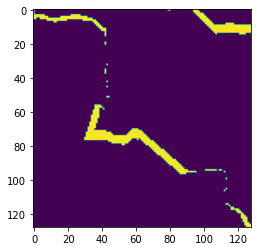

In [47]:
plt.imshow(multilayer[..., 6])